### Gamma Ray Bursts Data Clustering

Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed?

In [1]:
import requests
import numpy as np

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
raw = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names = np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

C:\Users\ricca\AppData\Local\Temp\ipykernel_14136\2158404239.py:10: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  raw = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')


https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt

https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html

In [2]:
print(names)

['GRB_name' 'GRB_name_Fermi' 'T0' 'ra' 'decl' 'pos_error' 'T90'
 'T90_error' 'T90_start' 'fluence' 'fluence_error' 'redshift' "'T100'"
 'GBM_located' 'mjd_(T0)']


We have to clean data!\
Some data are flagged by '-999'

In [7]:
T90, flux = zip(*[(float(a), float(b)) for a, b in zip(raw[6], raw[9]) if a != '-999' and b != '-999' and float(b)!=0])

In [8]:
T90  = np.array(T90)
flux = np.array(flux)

In [9]:
T90 = np.log10(T90)
flux= np.log10(flux)

In [10]:
import matplotlib.pyplot as plt
import plot_settings

In [11]:
X = np.vstack([T90, flux])

In [12]:
X = X.T

Text(0, 0.5, 'log(Flux) $\\left[\\frac{\\text{KeV}}{\\text{cm}^2}\\right]$')

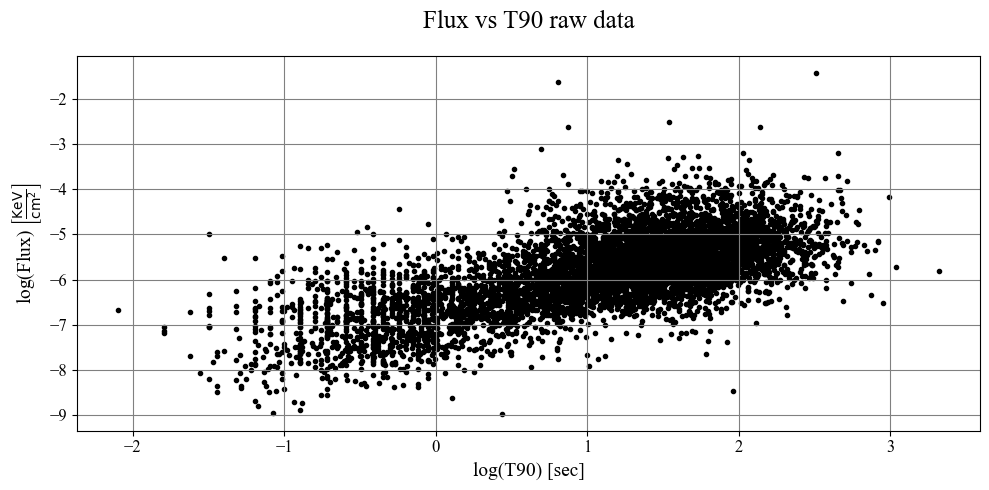

In [13]:
plt.scatter(X[:,0],X[:,1],color='black', marker='.')
plt.title('Flux vs T90 raw data')
plt.xlabel('log(T90) [sec]')
plt.ylabel(r'log(Flux) $\left[\frac{\text{KeV}}{\text{cm}^2}\right]$')

In [14]:
from sklearn.cluster import KMeans

In [15]:
n_clusters = 3

In [16]:
init = np.array([[50, 1e3],[0.5, 1e2]])

In [17]:
instance = KMeans(n_clusters, verbose=1, tol=1e-6, algorithm='elkan')

In [ ]:
instance.fit(X)

Initialization complete
Iteration 0, inertia 4585.449698069186
Iteration 1, inertia 3667.0105314396583
Iteration 2, inertia 3297.0173193840283
Iteration 3, inertia 3117.306106313841
Iteration 4, inertia 3026.585130928129
Iteration 5, inertia 2980.4328952584588
Iteration 6, inertia 2956.635924136094
Iteration 7, inertia 2944.854298921235
Iteration 8, inertia 2938.1272977759563
Iteration 9, inertia 2934.2725428627164
Iteration 10, inertia 2931.663553148377
Iteration 11, inertia 2929.974082464385
Iteration 12, inertia 2929.184198964834
Iteration 13, inertia 2928.7434653149858
Iteration 14, inertia 2928.5642147391472
Iteration 15, inertia 2928.4344750152477
Iteration 16, inertia 2928.349470332705
Iteration 17, inertia 2928.305692866087
Iteration 18, inertia 2928.2834989810294
Iteration 19, inertia 2928.234914890086
Iteration 20, inertia 2928.1689036608695
Iteration 21, inertia 2928.0930831958867
Iteration 22, inertia 2928.0439529045807
Iteration 23, inertia 2928.00411321888
Iteration 24, i

KMeans(algorithm='elkan', n_clusters=3, tol=1e-06, verbose=1)

In [ ]:
centers = instance.cluster_centers_ #location of the clusters
labels = instance.predict(X) #labels for each of the points

In [20]:
np.unique(labels)

array([0, 1, 2], dtype=int32)

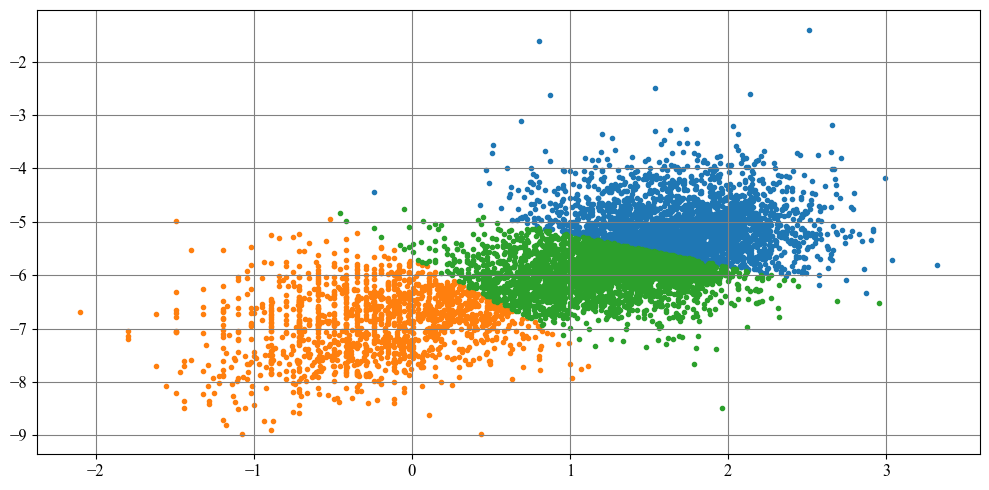

In [21]:
for i in np.unique(labels):
    plt.scatter(X[labels==i].T[0],X[labels==i].T[1],marker='.')

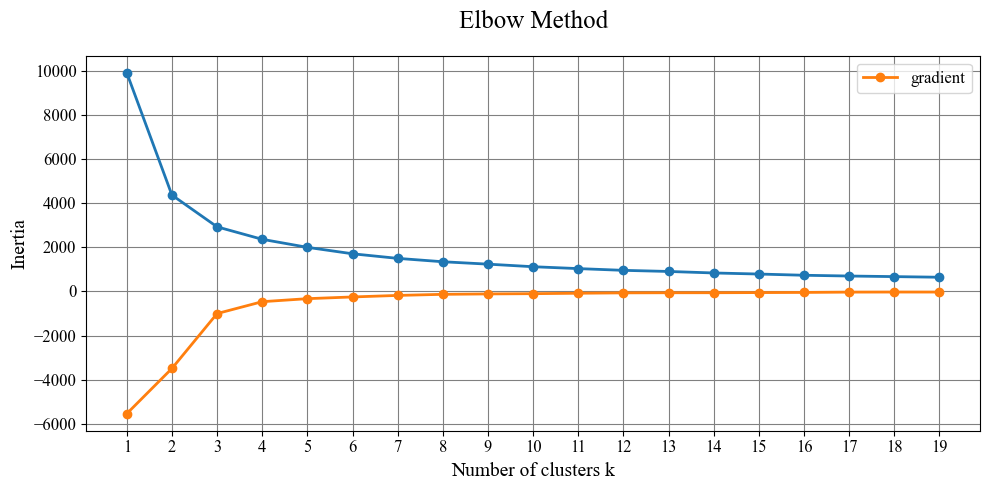

In [22]:
inertia = []
k_range = range(1, 20)  # Try between 1 and 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot
plt.plot(k_range, inertia, 'o-')
plt.plot(k_range,np.gradient(inertia), 'o-', label='gradient')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.xticks(k_range)
plt.legend()


In [29]:
from sklearn.metrics import silhouette_score

In [30]:
SS = silhouette_score(X, labels)

In [33]:
print(f'Mean Silhouette score : {SS:.2f}')

Mean Silhouette score : 0.39


In [9]:
from sklearn.mixture import GaussianMixture

In [ ]:
bic_scores = []
n_components_range = range(1, 21)

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(X)
    bic_scores.append(gmm.bic(X))

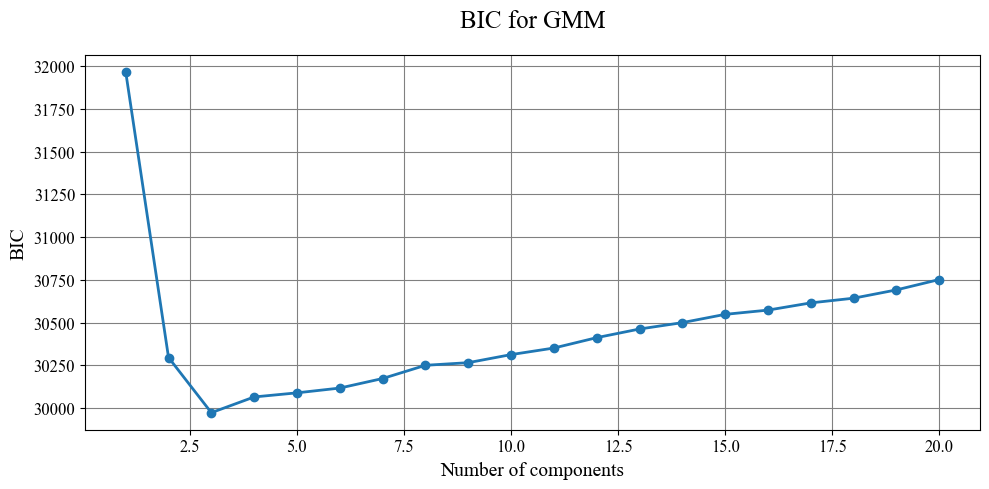

In [65]:
# Plot BIC
plt.plot(n_components_range, bic_scores, 'o-')
plt.xlabel('Number of components')
plt.ylabel('BIC')
plt.title('BIC for GMM')
plt.show()

In [66]:
best_n_components = 3
print(f"Best number of clusters: {best_n_components}")

Best number of clusters: 3


In [67]:
best_gmm = GaussianMixture(n_components=best_n_components, random_state=0)
labels = best_gmm.fit_predict(X)

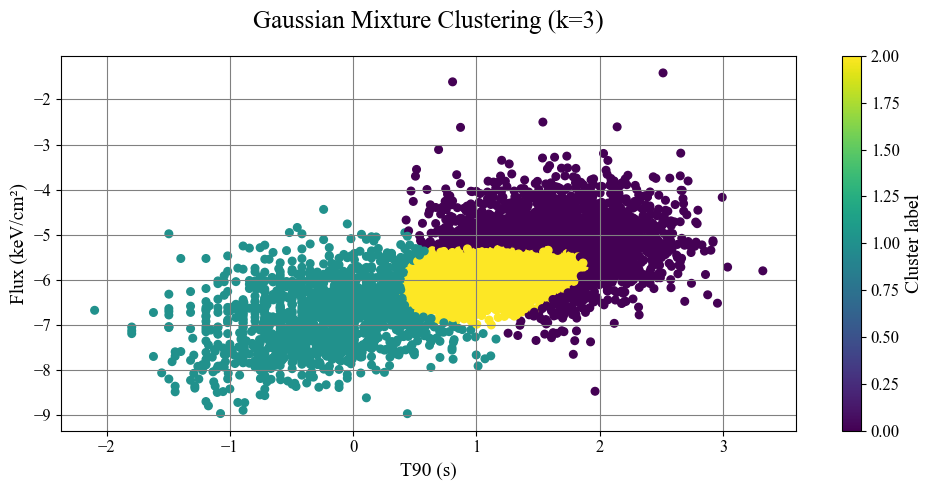

In [68]:
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30)
plt.xlabel('T90 (s)')
plt.ylabel('Flux (keV/cm²)')
plt.title(f'Gaussian Mixture Clustering (k={best_n_components})')
plt.colorbar(label='Cluster label')

Let's try now with more then 2 dimensions!

In [45]:
T90, fluence, RS = zip(*[(float(a), float(b), float(c)) for a, b, c in zip(raw[6], raw[9], raw[12]) if a != '-999' and b != '-999' and float(b)!=0 and c != '-999'])

In [46]:
Y = np.vstack([T90, fluence, RS])

In [47]:
Y=Y.T

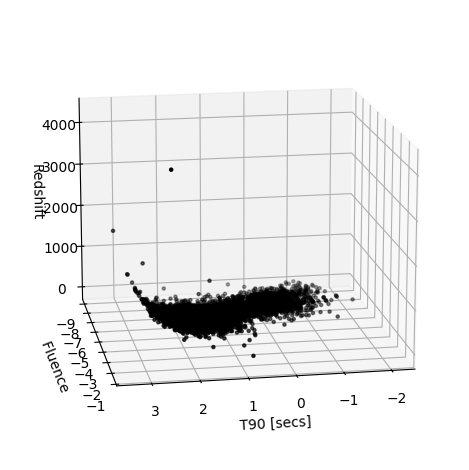

In [48]:
fig = plt.figure()
ax  = fig.add_subplot(projection='3d')
ax.scatter(np.log10(T90), np.log10(fluence), RS, marker='.',color='black')
ax.set_xlabel('T90 [secs]')
ax.set_ylabel('Fluence   ')
ax.set_zlabel('Redshift')

ax.view_init(elev=15, azim=80)  # ← rotate here
fig.tight_layout()

In [49]:
gmm = GaussianMixture(n_components=4, random_state=0)

In [50]:
gmm.fit(Y)

GaussianMixture(n_components=4, random_state=0)

In [51]:
print('BIC = ', gmm.bic(Y))

BIC =  -43071.6209269163


In [52]:
labels3 = gmm.fit_predict(Y)

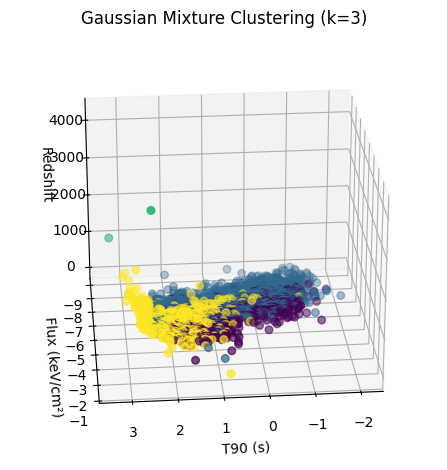

In [56]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(np.log10(Y[:, 0]), np.log10(Y[:, 1]), Y[:, 2], c=labels3, s=30)
ax.set_xlabel('T90 (s)')
ax.set_ylabel('Flux (keV/cm²)')
ax.set_zlabel('Redshift')
ax.set_title(f'Gaussian Mixture Clustering (k={3})')

ax.view_init(elev=25, azim=85)  # ← rotate here
fig.tight_layout()

In [37]:
from sklearn.cluster import KMeans

In [40]:
instance = KMeans(3, verbose=1, tol=1e-6, algorithm='elkan')
instance.fit(Y)
centers = instance.cluster_centers_ #location of the clusters
labels31 = instance.predict(Y) #labels for each of the points

Initialization complete
Iteration 0, inertia 45926315.869213074
Iteration 1, inertia 37450207.02206303
Iteration 2, inertia 37330691.544592805
Iteration 3, inertia 37279709.01780881
Iteration 4, inertia 37272054.310133815
Iteration 5, inertia 37243233.59240886
Iteration 6, inertia 37212666.26976654
Iteration 7, inertia 37200125.185607746
Iteration 8, inertia 37199104.293060035
Iteration 9, inertia 37195839.39853182
Iteration 10, inertia 37195215.26036386
Iteration 11, inertia 37194697.01099903
Iteration 12, inertia 37194243.01997544
Iteration 13, inertia 37194150.35464972
Iteration 14, inertia 37194138.26183314
Converged at iteration 14: strict convergence.


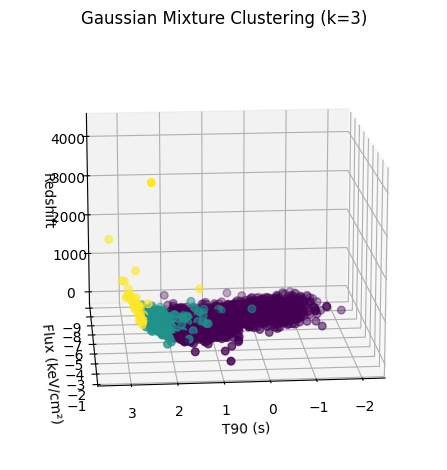

In [42]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(np.log10(Y[:, 0]), np.log10(Y[:, 1]), Y[:, 2], c=labels31, cmap='viridis', s=30)
ax.set_xlabel('T90 (s)')
ax.set_ylabel('Flux (keV/cm²)')
ax.set_zlabel('Redshift')
ax.set_title(f'Gaussian Mixture Clustering (k={3})')

ax.view_init(elev=15, azim=85)  # ← rotate here
fig.tight_layout()

KMeans shift